# Data Description
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in yyyy-mm-dd format The local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

In [1]:
# pip install xgboost

## Importing Libraries

In [2]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
data = pd.read_csv('SolarPrediction.csv')

In [4]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [6]:
data.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

## Data Wrangling

In [7]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [8]:
df = data.copy()

In [9]:
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [11]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [12]:
df['RiseHour'] = pd.to_datetime(df['TimeSunRise']).dt.hour.astype(int)
df['RiseMinute'] = pd.to_datetime(df['TimeSunRise']).dt.minute.astype(int)

df['SetHour'] = pd.to_datetime(df['TimeSunSet']).dt.hour.astype(int)
df['SetMinute'] = pd.to_datetime(df['TimeSunSet']).dt.minute.astype(int)

In [13]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [14]:
df.drop(columns = ['Data','UNIXTime', 'TimeSunRise', 'TimeSunSet', 'Time'], inplace = True)

In [15]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [16]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

In [17]:
print(f"input_features-shape : {input_features.shape}")
print(f"target-shape : {target.shape}")

input_features-shape : (32686, 14)
target-shape : (32686,)


## Correlation Matrix

In [18]:
df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


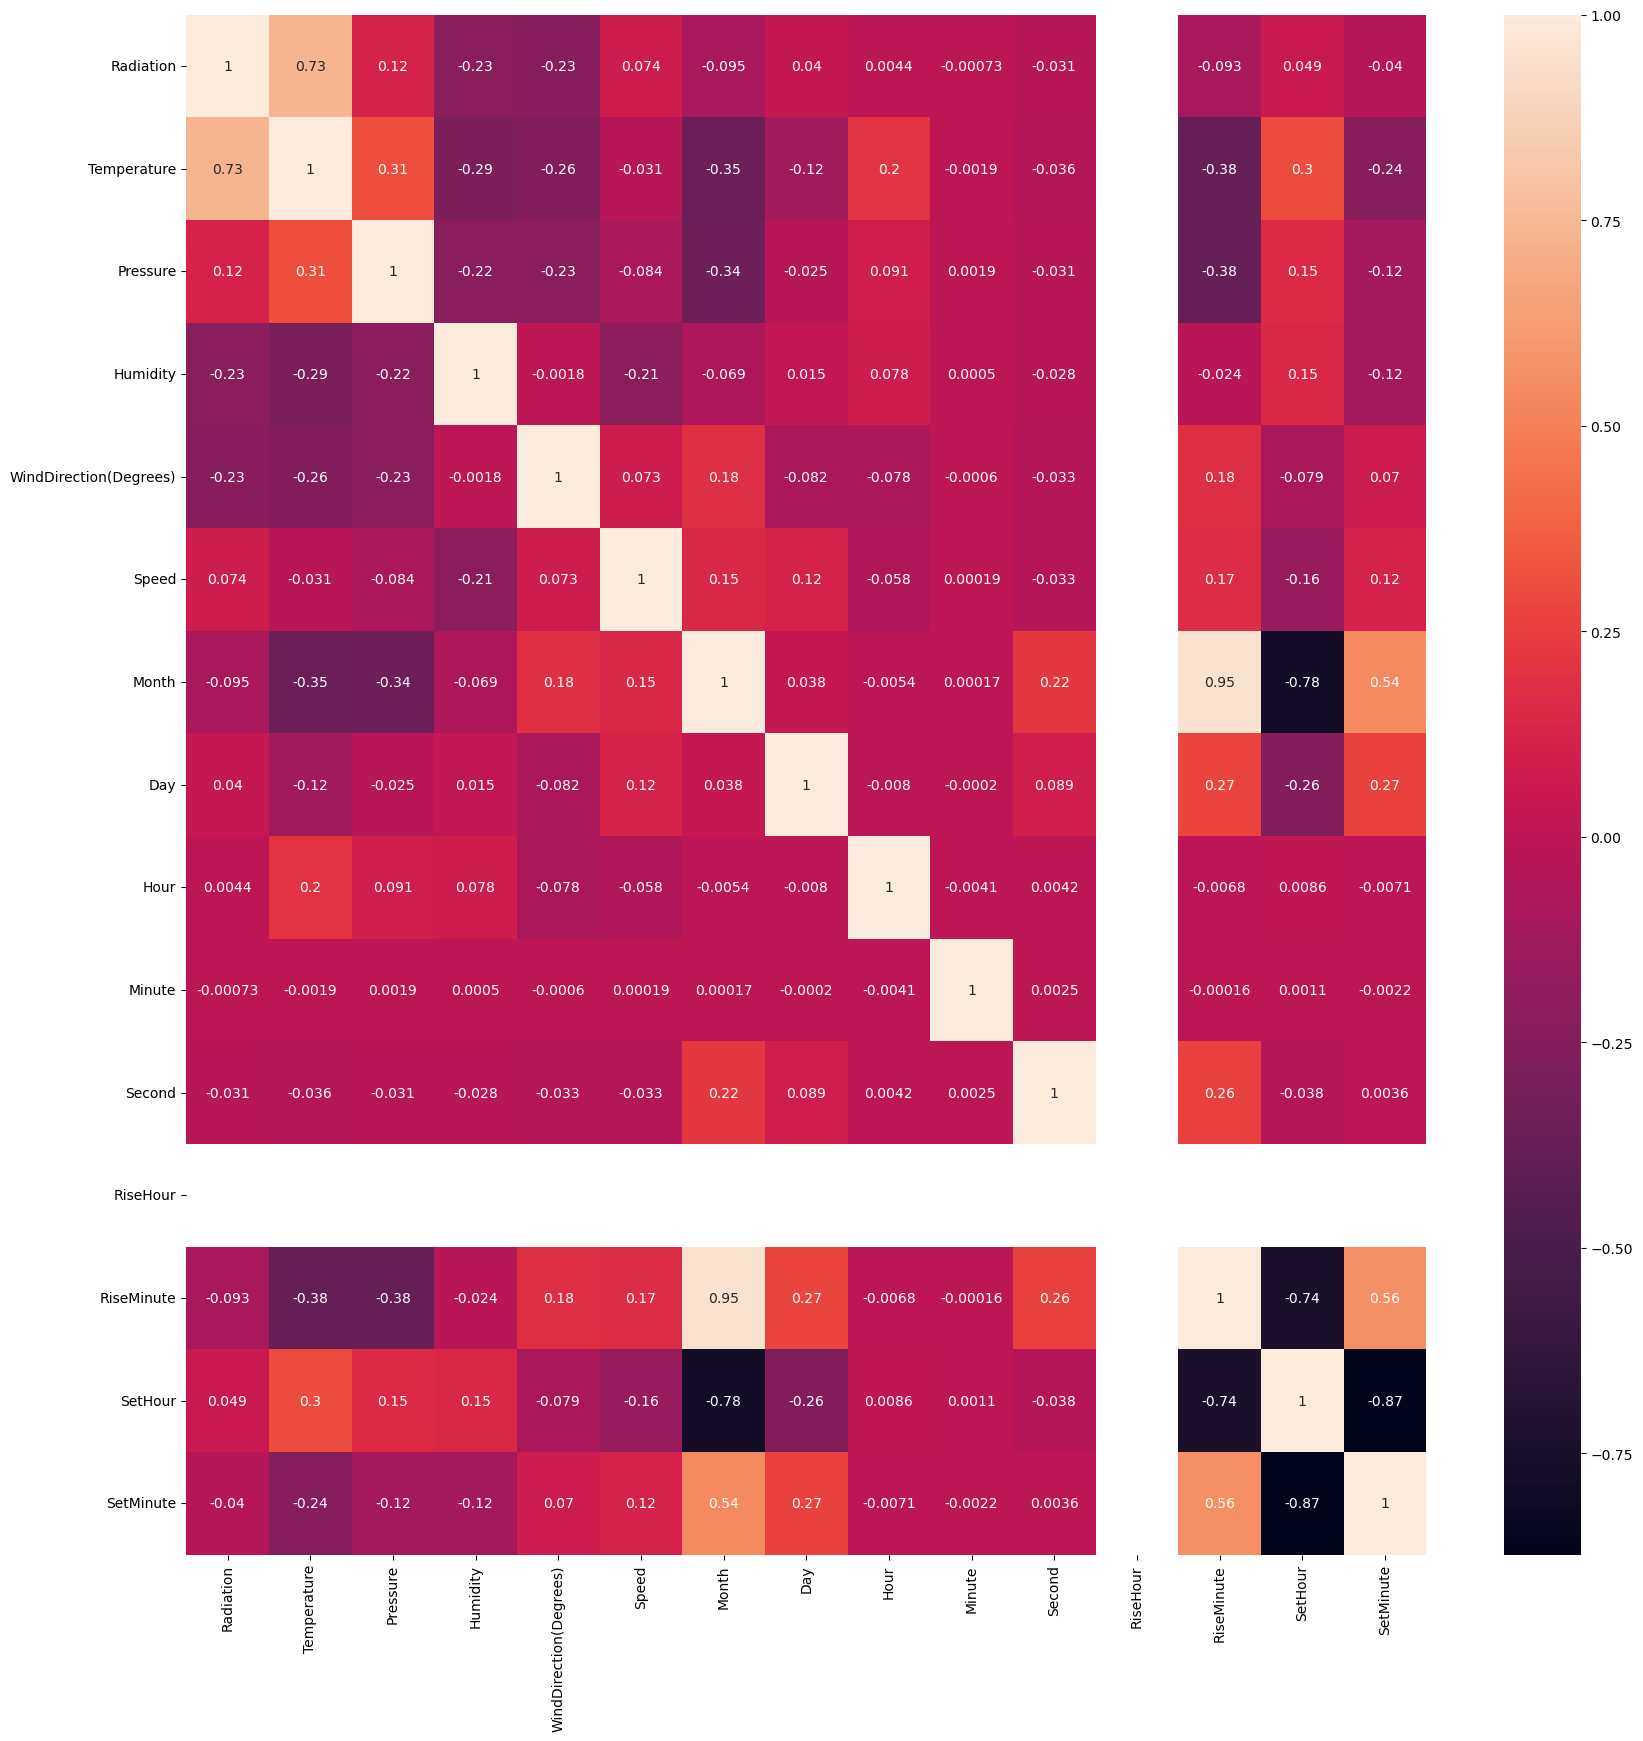

In [19]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True)
plt.show()

## Feature Selection using SelectKBest Method

Since the correlation matrix doesnot show the relation between the Day Month and Hour with Radiance, there is a need to consider other methods

In [20]:
best_features = SelectKBest(score_func=chi2, k = 10)

Importing Label Encoder for the Kbest method to convert into labels

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(target)

In [23]:
Y_train

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [24]:
scaled_input = MinMaxScaler().fit_transform(input_features)
fit = best_features.fit(scaled_input, df['Radiation'].apply(lambda x : int(x * 100)))

In [25]:
fit.scores_

array([ 1651.68563214,   523.79106046,  1588.08743322,  3271.82727734,
         765.85977881,  4684.57961042,  2841.92685032,   691.18539264,
        2702.44933263,  2288.67303161,            nan,  4015.06277087,
       12207.53145397,  1863.71208749])

In [26]:
scores = pd.DataFrame(fit.scores_)
features = pd.DataFrame(np.array(input_features.columns))

feature_scores = pd.concat([features,scores], axis = 1)

In [27]:
feature_scores.columns = ['Features', 'Score']

In [28]:
feature_scores.sort_values(by = 'Score', ascending = False, inplace = True)

In [29]:
feature_scores

,Features,Score
12,SetHour,12207.531454
5,Month,4684.579610
11,RiseMinute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,SetMinute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


Text(0.5, 0, 'features')

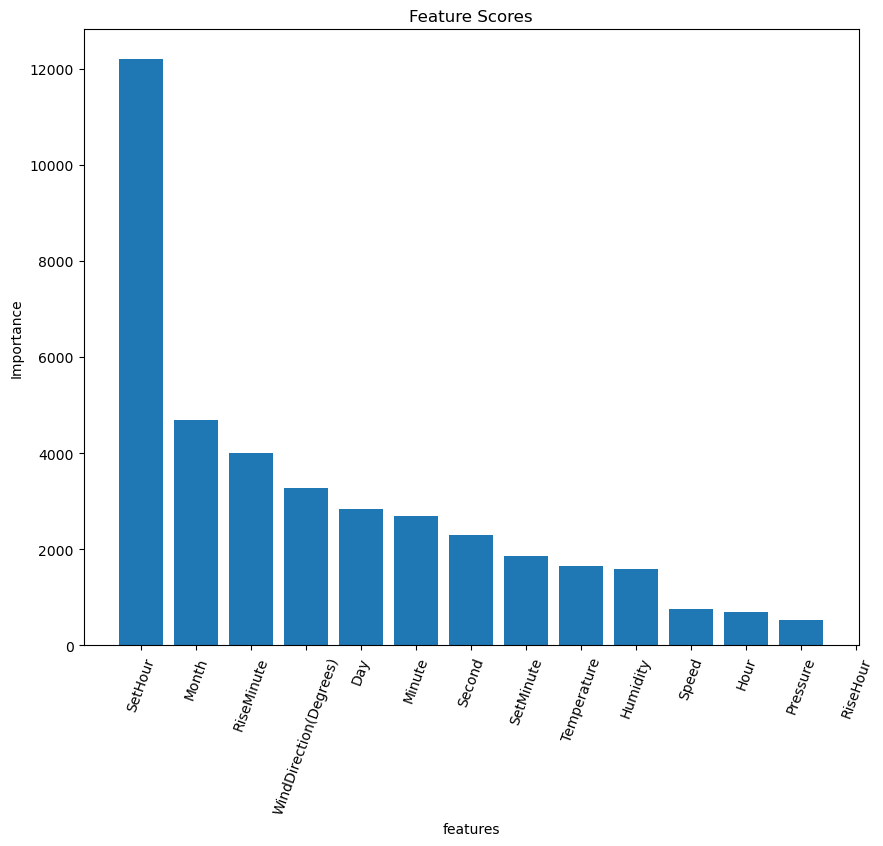

In [30]:
plt.figure(figsize = (10,8))
plt.bar(feature_scores['Features'], feature_scores['Score'])
plt.title('Feature Scores')
plt.xticks(rotation = 70)
plt.ylabel('Importance')
plt.xlabel('features')

## Feature Selection using Extra Tree Classifier

In [31]:
target_cont = df['Radiation'].apply(lambda x : int(x * 100))
model = ExtraTreesClassifier(verbose= 2, n_estimators = 7)
model.fit(scaled_input, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 7


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.1min finished


ExtraTreesClassifier(n_estimators=7, verbose=2)

In [33]:
feature_imp = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ['feature_imp'])
feature_imp.sort_values(by = 'feature_imp', ascending = False, inplace = True)
feature_imp

,feature_imp
WindDirection(Degrees),0.158469
Minute,0.150077
Speed,0.127214
Second,0.124032
Humidity,0.110317
Hour,0.089396
Temperature,0.079536
Pressure,0.076147
Day,0.034098
SetMinute,0.023420


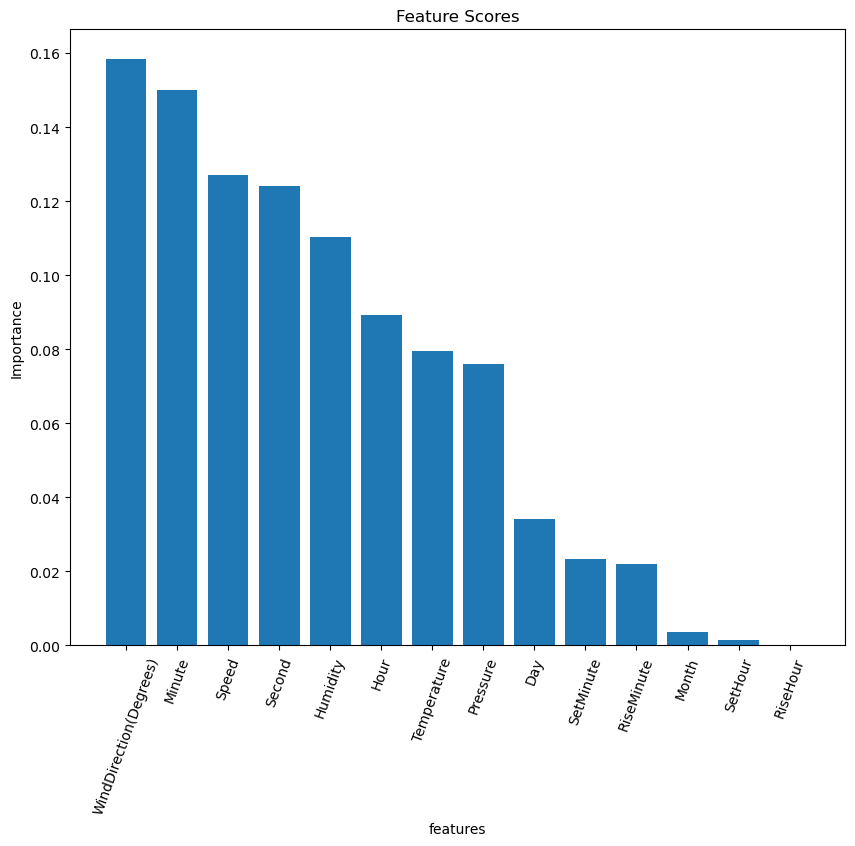

In [35]:
plt.figure(figsize = (10,8))
plt.bar(feature_imp.index, feature_imp['feature_imp'])
plt.title('Feature Scores')
plt.xticks(rotation = 70)
plt.ylabel('Importance')
plt.xlabel('features')
plt.show()

## Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

In [36]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


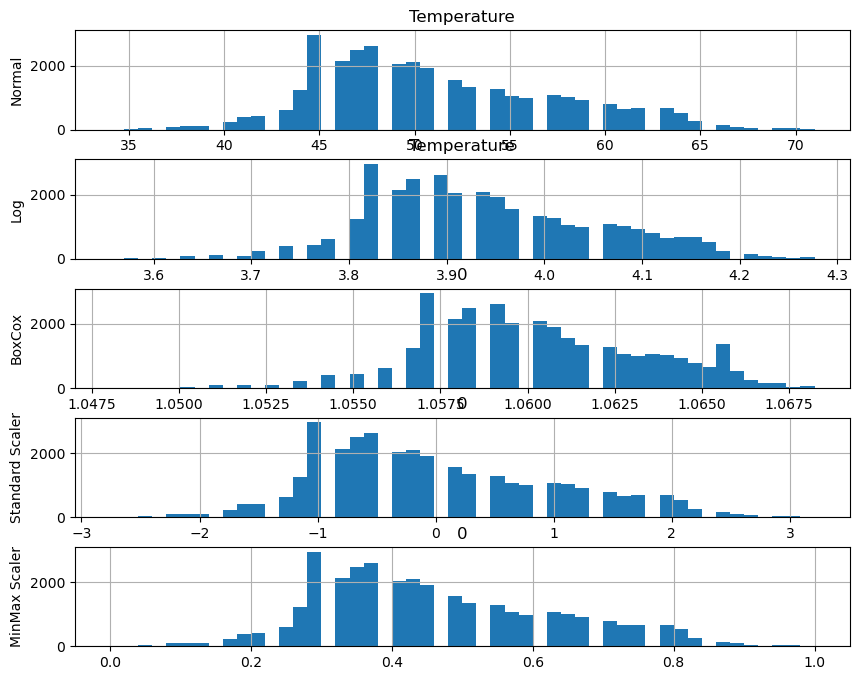

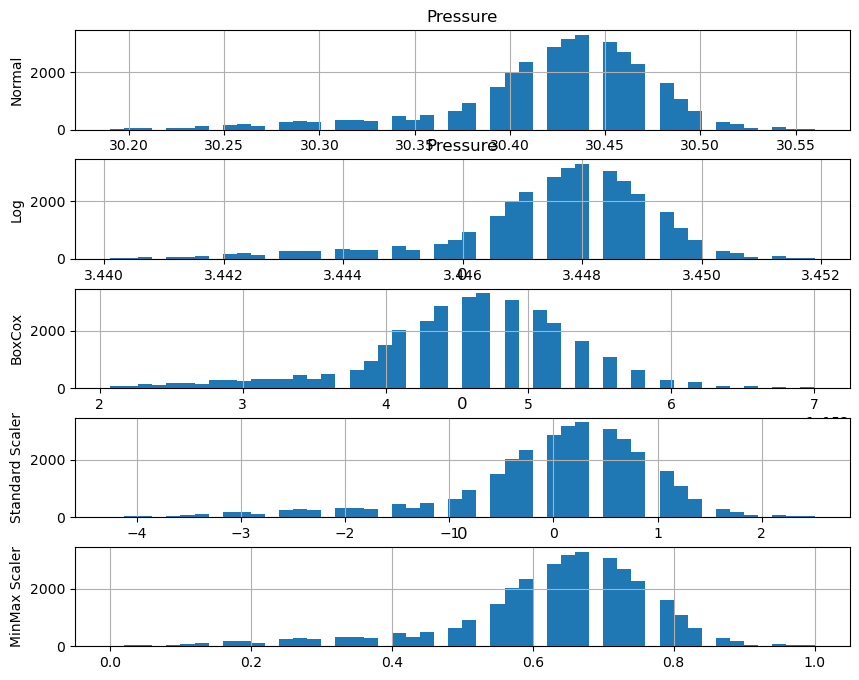

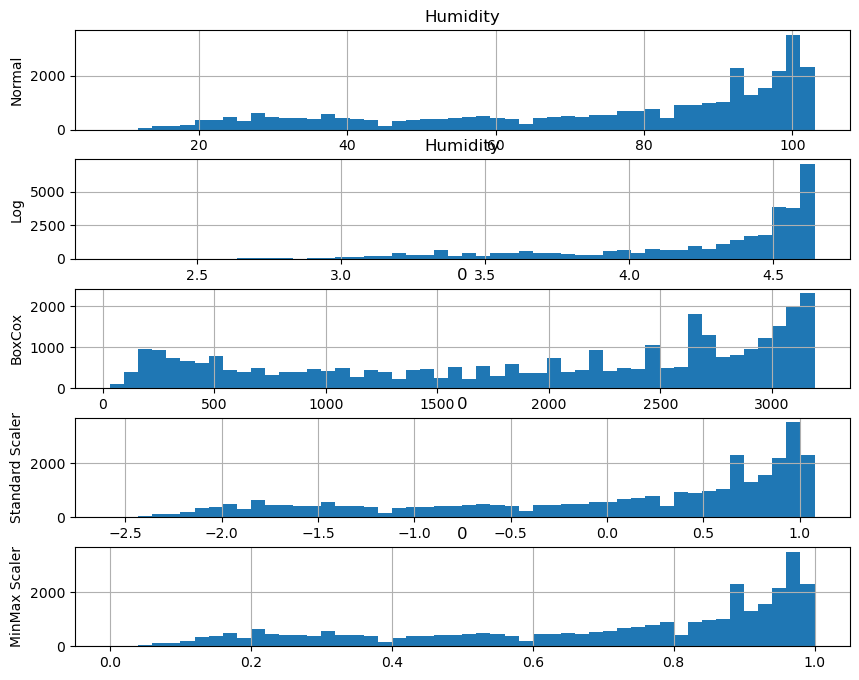

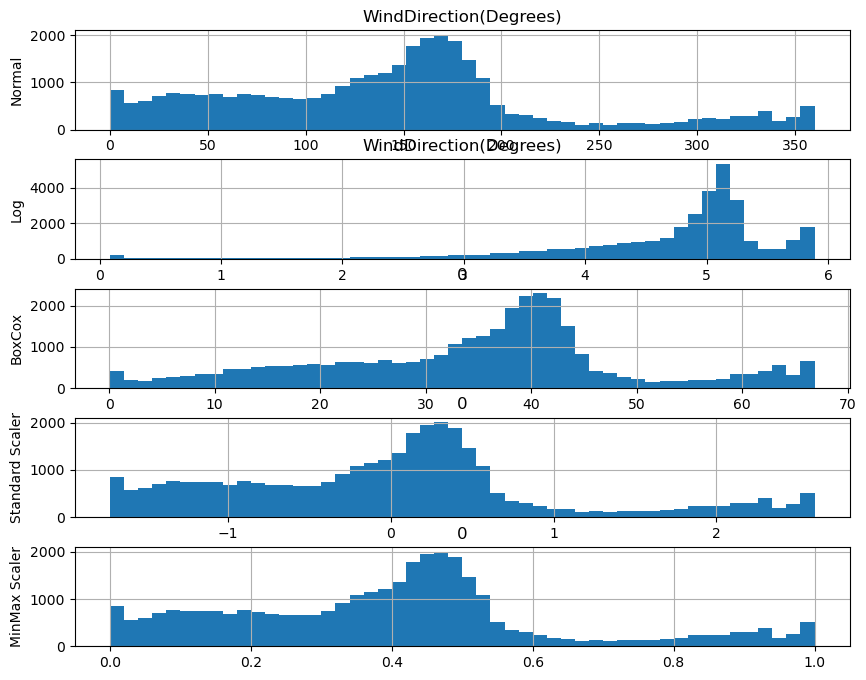

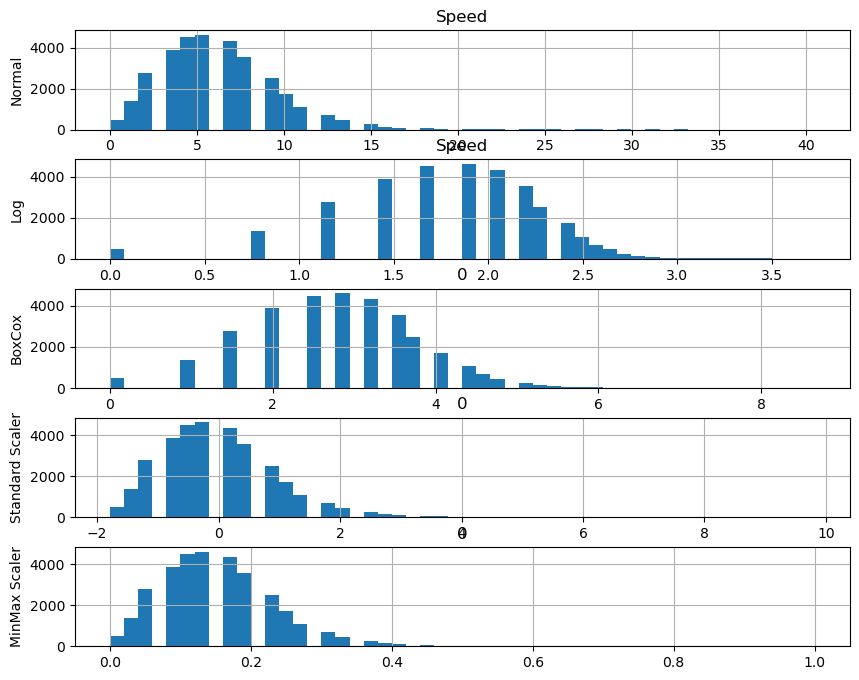

In [40]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize = (10,8))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i] + 1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i] + 1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('Standard Scaler')
    ax5.set_ylabel('MinMax Scaler')

In [41]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [42]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


## Preparing data - Standardisation and Splitting

In [43]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [44]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

## Prediction with XGBoost

In [70]:
params = {
    'learning_rate' : 0.1,
    'depth' : 10
}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [71]:
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, depth=10, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [72]:
y_pred = model.predict(xtest)

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 85.30
R2: 0.93


## Using MultiLayer Perceptron for prediction

In [76]:
model = None
model = Sequential()

model.add(Dense(128, activation='relu', input_dim = 14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics=['mse'], loss = 'mae', optimizer = Adam(learning_rate = 0.001))
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
history = model.fit(xtrain, ytrain, validation_split= 0.1, epochs=50, batch_size = 32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 156.5767 - mse: 89617.5781 - val_loss: 86.6792 - val_mse: 26994.0645
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 87.4634 - mse: 28808.3926 - val_loss: 76.2297 - val_mse: 21313.2598
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 83.1947 - mse: 26621.1855 - val_loss: 71.7922 - val_mse: 19773.9785
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 81.9068 - mse: 25814.7734 - val_loss: 68.9231 - val_mse: 18342.3477
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 77.9326 - mse: 23588.0684 - val_loss: 65.6888 - val_mse: 16598.6367
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 74.7426 - mse: 21547.8496 - val_loss: 62.5014 - val_mse: 15533.4805
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 72.8618 - mse: 20775.1230 - val_loss: 61.7035 - val_mse: 15135.4658
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 72.3501 - mse: 20229.5059 - val_loss: 59.08

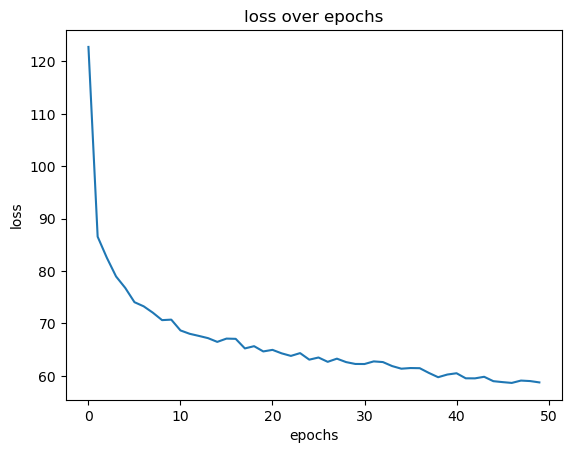

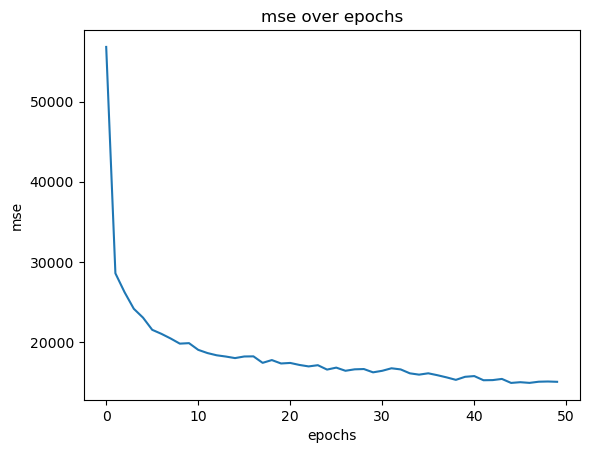

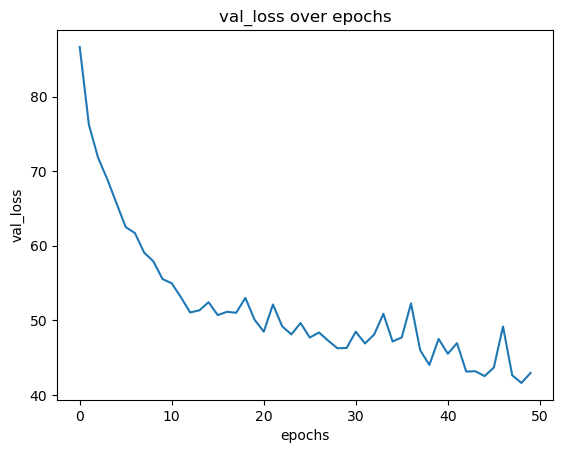

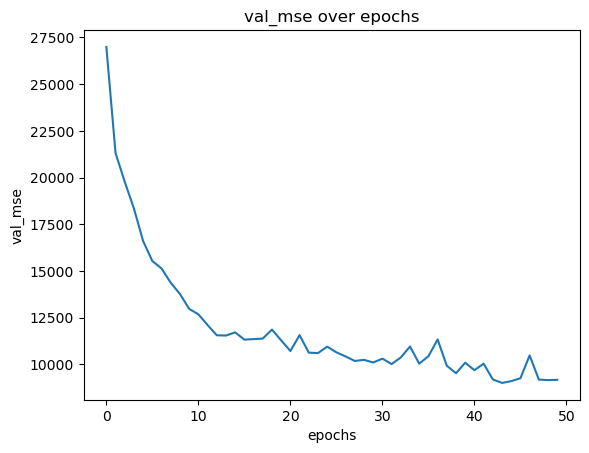

In [78]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [79]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]

print(mse, mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.1624 - mse: 9955.8350
9944.4384765625 43.24739456176758
